## Install & Imports

In [105]:
import datetime as dt
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
#!pip install pandas-datareader
from pandas_datareader import data as pdr
from IPython.display import clear_output
import warnings
warnings.filterwarnings("ignore")
clear_output()

In [106]:
#from google.colab import drive
#drive.mount('/content/drive')

In [107]:
#!pip install yfinance
#!conda install -c ranaroussi yfinance --y
import yfinance as yf # requires yfinance - pip install yfinance
clear_output()

In [108]:
#!pip install backtesting
clear_output()
# Библиотеки backtesting
from backtesting import Backtest, Strategy

In [109]:
!curl --remote-name --location https://raw.githubusercontent.com/chekh/ai_tr_libs/main/Long_n_short_strategy.py
!curl --remote-name --location https://raw.githubusercontent.com/chekh/ai_tr_libs/main/Long_strategy.py
clear_output()
# Библиотеки из ai_tr_libs
from Long_n_short_strategy import Long_n_Short_Strategy as LnS
from Long_strategy import Long_Strategy as LS

# Пример работы кода на тренировочной выборке
----
- interval = '1h'
- window = 2

## Загружаем данные

In [202]:
# Начните с активации обходного пути Yahoo Finance и установки начальной и конечной точек фрейма данных.
# здесь Yf.pdr_override () активирует ваши условия обходного пути, а остальное установит ваш фрейм данных.
yf.pdr_override()

start = '2020-01-01'
end = '2021-12-31'
window = 2
test_size = 210 # для теста откусим последние test_size значений

now = dt.datetime.now()
interval = '1h'
stock = 'POLY.ME'

buy_signals = pd.DataFrame() # dataframe для записи сигналов
sell_signals = pd.DataFrame() # dataframe для записи сигналов

In [203]:
data = pdr.get_data_yahoo(stock,
                          start,
                          #end,
                          now,
                          interval = interval) # interval=60min is not supported. Valid intervals: [1m, 2m, 5m, 15m, 30m, 60m, 90m, 1h, 1d, 5d, 1wk, 1mo, 3mo]
del data['Adj Close'], data['Volume']
data.index.name = 'Date'

df_test = data[-test_size:] # Тестовая выборка для симуляции торговли в реальном времени

df = data[:-test_size]
df

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close
Date,,,,
2020-01-03 09:30:00+03:00,978.400024,980.000000,967.099976,976.200012
2020-01-03 10:30:00+03:00,976.000000,984.599976,973.099976,982.500000
2020-01-03 11:30:00+03:00,983.000000,983.099976,980.299988,981.200012
2020-01-03 12:30:00+03:00,981.700012,984.000000,980.200012,982.200012
2020-01-03 13:30:00+03:00,983.000000,988.599976,982.799988,986.400024
...,...,...,...,...
2021-05-06 14:30:00+03:00,1595.300049,1611.500000,1595.000000,1610.800049
2021-05-06 15:30:00+03:00,1610.699951,1612.699951,1601.599976,1602.400024
2021-05-06 16:30:00+03:00,1602.400024,1637.599976,1602.400024,1631.199951


In [204]:
# Тестовая выборка для симуляции торговли в реальном времени
df_test

,Open,High,Low,Close
Date,,,,
2021-05-07 09:30:00+03:00,1631.699951,1647.000000,1631.699951,1639.500000
2021-05-07 10:30:00+03:00,1640.199951,1644.199951,1638.900024,1642.199951
2021-05-07 11:30:00+03:00,1642.099976,1659.099976,1641.000000,1658.599976
2021-05-07 12:30:00+03:00,1657.599976,1661.199951,1647.300049,1648.500000
2021-05-07 13:30:00+03:00,1648.599976,1655.000000,1648.199951,1649.400024
...,...,...,...,...
2021-06-04 14:30:00+03:00,1728.800049,1731.199951,1724.900024,1725.099976
2021-06-04 15:30:00+03:00,1725.199951,1759.800049,1725.199951,1755.400024
2021-06-04 16:30:00+03:00,1756.000000,1759.900024,1753.900024,1759.000000


## Разметка Y

In [205]:
## Размечаем Y

#from pandas_datareader import data as pdr 
#import datetime as dt


def SELL(data, counter_lvl, plotting):
    
    signals = pd.DataFrame() # dataframe для записи сигналов

    #df['High'].plot(label='high')
    if plotting == True:
        plt.figure(figsize=(22, 8))
        data['Close'].plot(label='close')
        
    pivots =[]
    dates = []
    counter = 0
    lastPivot = 0
    Range = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
    daterange = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
        
    for i in data.index:
        currentMax = max(Range , default=0)
        value=data['Close'][i]
            
        Range=Range[1:19]
        Range.append(value)
        daterange=daterange[1:19]
        daterange.append(i)
            
        if currentMax == max(Range , default=0):
            counter+=1
        else:
            counter = 0
        if counter ==  counter_lvl:
            lastPivot = currentMax
            dateloc = Range.index(lastPivot)
            lastDate = daterange[dateloc]
            pivots.append(lastPivot)
            dates.append(lastDate)

    for index in range(1, len(pivots)):
        line = pd.DataFrame({'Date':[dates[index]], 'price':[pivots[index]], 'Signal':[-1]})
        signals = signals.append(line, ignore_index=True)

        if plotting == True:
            plt.plot_date([dates[index], dates[index]],
            [pivots[index], pivots[index]], marker='v', color='red')

    if plotting == True:
        plt.grid()
        plt.show()

    return signals
    


def BUY(data, counter_lvl, plotting):
    
    signals = pd.DataFrame() # dataframe для записи сигналов

    #df['Low'].plot(label='low')
    if plotting == True:
        plt.figure(figsize=(22, 8))
        data['Close'].plot(label='close')
        
    pivots =[]
    dates = []
    counter = 0
    lastPivot = 0
    Range = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
    daterange = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
        
    for i in data.index:
        currentMax = min(Range , default=0)
        value=data['Close'][i]
        
            
        Range=Range[1:20]
        Range.append(value)
        daterange=daterange[1:20]
        daterange.append(i)
            
        if currentMax == min(Range , default=0):
            counter+=1
        else:
            counter = 0
        if counter ==  counter_lvl:
            lastPivot=currentMax
            dateloc =Range.index(lastPivot)
            lastDate = daterange[dateloc]
            pivots.append(lastPivot)
            dates.append(lastDate)

    for index in range(1, len(pivots)):
        line = pd.DataFrame({'Date':[dates[index]], 'price':[pivots[index]], 'Signal':[1]})
        signals = signals.append(line, ignore_index=True)

        if plotting == True:
            plt.plot_date([dates[index], dates[index]],
            [pivots[index], pivots[index]], marker='^', color='green')

    if plotting == True:
        plt.grid()
        plt.show()

    return signals
    

In [206]:
#import os
#os.chdir('/content/drive/MyDrive/_Проекты/AI_Trading/AI-trading_courses/4. НС и торговля по паттернам/Подбор оптимальных параметров')
#from markup_y import SELL, BUY

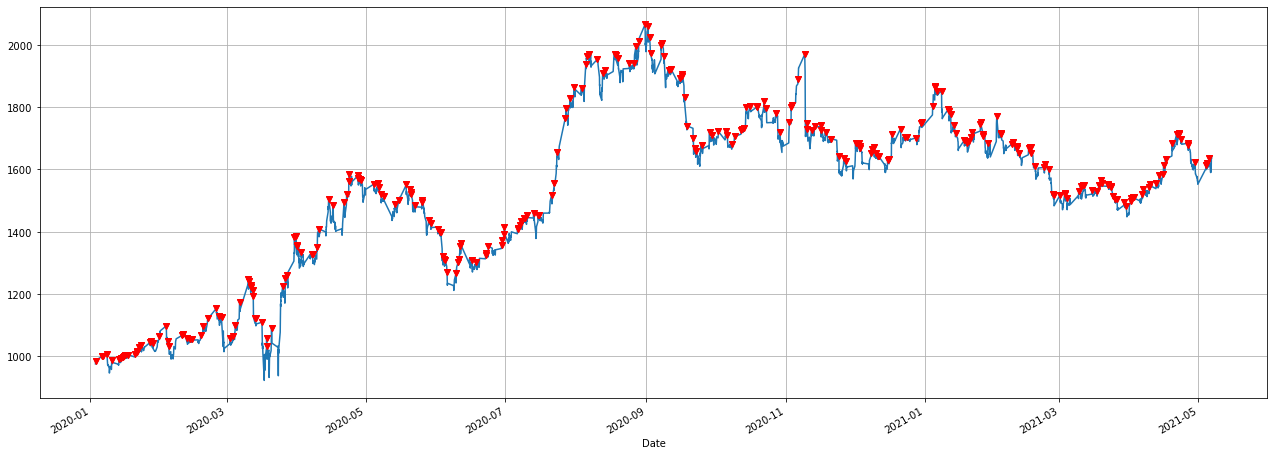

In [207]:
sell_signals = SELL(df, counter_lvl = window, plotting = True)
sell_signals = sell_signals.set_index('Date')
#sell_signals[-10:]

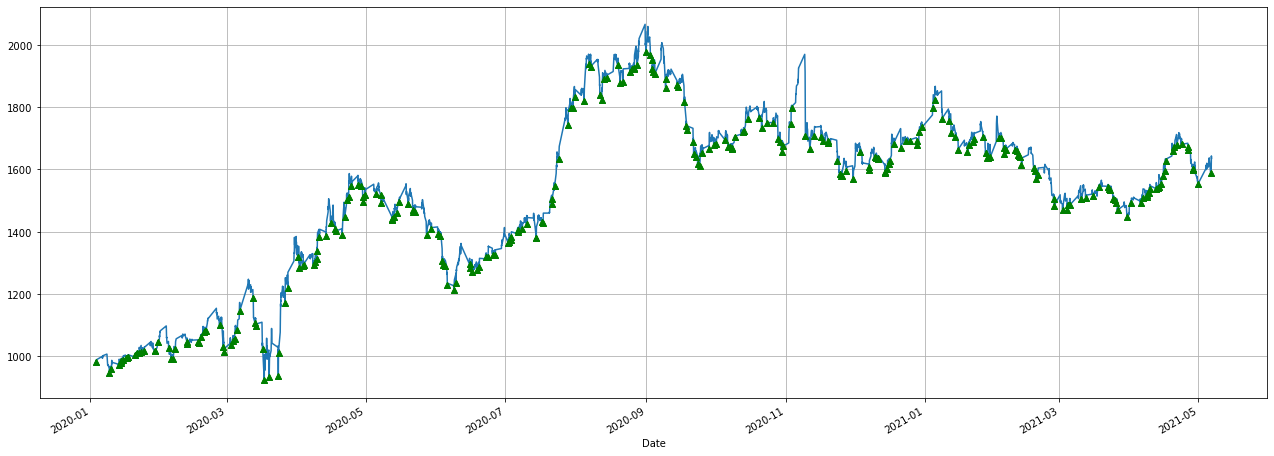

In [208]:
buy_signals = BUY(df, counter_lvl = window, plotting=True)
buy_signals = buy_signals.set_index('Date')
#buy_signals[-10:]

## Обьединение датафреймов

In [209]:
signals = sell_signals.append(buy_signals)
signals.index.rename('Date', inplace=True)
signals.sort_index(inplace=True) # сортируем по индексу
signals[-5:]

,price,Signal
Date,,
2021-04-30 18:30:00+03:00,1552.400024,1
2021-05-04 10:30:00+03:00,1614.400024,-1
2021-05-04 16:30:00+03:00,1620.000000,-1
2021-05-05 18:30:00+03:00,1637.300049,-1
2021-05-06 09:30:00+03:00,1590.199951,1


In [210]:
df_new = df

df_new = pd.merge(df_new, signals['Signal'], on=('Date'), how ='left')
df_new = df_new.replace('',np.nan).ffill() # заменяем последующие значения на предыдущий сигнал
#df_new.loc[df_new['Signal'] != 0]
#df_new = df_new.ffill()
df_new[-15:]

,Open,High,Low,Close,Signal
Date,,,,,
2021-05-05 14:30:00+03:00,1629.699951,1632.000000,1625.000000,1626.300049,-1.0
2021-05-05 15:30:00+03:00,1626.500000,1634.900024,1620.800049,1629.800049,-1.0
2021-05-05 16:30:00+03:00,1629.300049,1636.199951,1624.599976,1626.599976,-1.0
2021-05-05 17:30:00+03:00,1626.099976,1637.000000,1625.699951,1635.400024,-1.0
2021-05-05 18:30:00+03:00,1635.400024,1638.099976,1634.500000,1637.300049,-1.0
2021-05-06 09:30:00+03:00,1588.900024,1610.599976,1581.599976,1590.199951,1.0
2021-05-06 10:30:00+03:00,1589.800049,1604.500000,1588.099976,1599.599976,1.0
2021-05-06 11:30:00+03:00,1599.500000,1599.599976,1590.500000,1594.599976,1.0
2021-05-06 12:30:00+03:00,1594.599976,1597.099976,1590.400024,1592.400024,1.0


## График торговли

### Long

In [211]:
# Стратегия Long & Short (подключен класс стратегии LnS)
bt = Backtest(df_new, LS, cash=100000, commission=.004, trade_on_close=True)
stats = bt.run()
bt.plot(plot_volume=True, relative_equity=True)
stats

Start                     2020-01-03 09:30...
End                       2021-05-06 18:30...
Duration                    489 days 09:00:00
Exposure Time [%]                     57.6119
Equity Final [$]                  8.18256e+06
Equity Peak [$]                   8.18256e+06
Return [%]                            8082.56
Buy & Hold Return [%]                 67.5886
Return (Ann.) [%]                      2639.1
Volatility (Ann.) [%]                 872.561
Sharpe Ratio                          3.02454
Sortino Ratio                         440.513
Calmar Ratio                          247.149
Max. Drawdown [%]                    -10.6782
Avg. Drawdown [%]                   -0.575789
Max. Drawdown Duration        7 days 19:00:00
Avg. Drawdown Duration        0 days 18:00:00
# Trades                                  194
Win Rate [%]                          95.3608
Best Trade [%]                        30.1233
Worst Trade [%]                      -2.62271
Avg. Trade [%]                    

### Long & Short

In [212]:
# Стратегия Long & Short (подключен класс стратегии LnS)
bt = Backtest(df_new, LnS, cash=100000, commission=.004, trade_on_close=True)
stats = bt.run()
bt.plot(plot_volume=True, relative_equity=True)
stats

Start                     2020-01-03 09:30...
End                       2021-05-06 18:30...
Duration                    489 days 09:00:00
Exposure Time [%]                     99.8209
Equity Final [$]                  3.94885e+07
Equity Peak [$]                   3.94885e+07
Return [%]                            39388.5
Buy & Hold Return [%]                 67.5886
Return (Ann.) [%]                      8848.3
Volatility (Ann.) [%]                 3323.87
Sharpe Ratio                          2.66205
Sortino Ratio                         1144.04
Calmar Ratio                          804.408
Max. Drawdown [%]                    -10.9998
Avg. Drawdown [%]                   -0.747527
Max. Drawdown Duration        6 days 21:00:00
Avg. Drawdown Duration        0 days 19:00:00
# Trades                                  369
Win Rate [%]                          84.8238
Best Trade [%]                        19.9231
Worst Trade [%]                      -3.30948
Avg. Trade [%]                    

In [213]:
# журнал торговли
trade_journal = stats._trades

# Сохраним журнал торговли
file_name = 'outputs/trade_journal' + interval + '.csv'
trade_journal.to_csv(file_name, sep='\t')

trade_journal[-10:]

,Size,EntryBar,ExitBar,EntryPrice,ExitPrice,PnL,ReturnPct,EntryTime,ExitTime,Duration
359,22037,3247,3251,1701.378375,1718.300049,3.729029e+05,0.009946,2021-04-21 16:30:00+03:00,2021-04-22 10:30:00+03:00,0 days 18:00:00
360,-22292,3252,3268,1698.678000,1681.000000,3.940780e+05,0.010407,2021-04-22 11:30:00+03:00,2021-04-23 17:30:00+03:00,1 days 06:00:00
361,22670,3269,3270,1687.724000,1684.199951,-7.989019e+04,-0.002088,2021-04-23 18:30:00+03:00,2021-04-26 09:30:00+03:00,2 days 15:00:00
362,22733,3271,3273,1679.491249,1678.400024,-2.480681e+04,-0.000650,2021-04-26 10:30:00+03:00,2021-04-26 12:30:00+03:00,0 days 02:00:00
363,-22894,3274,3275,1666.606849,1661.300049,1.214939e+05,0.003184,2021-04-26 13:30:00+03:00,2021-04-26 14:30:00+03:00,0 days 01:00:00
364,22787,3276,3300,1679.792375,1624.199951,-1.266785e+06,-0.033095,2021-04-26 15:30:00+03:00,2021-04-29 09:30:00+03:00,2 days 18:00:00
365,-22970,3301,3319,1611.229151,1552.400024,1.351305e+06,0.036512,2021-04-29 10:30:00+03:00,2021-04-30 18:30:00+03:00,1 days 08:00:00
366,23821,3320,3321,1610.416000,1614.400024,9.490345e+04,0.002474,2021-05-04 09:30:00+03:00,2021-05-04 10:30:00+03:00,0 days 01:00:00
367,-24102,3322,3340,1595.592000,1590.199951,1.299592e+05,0.003379,2021-05-04 11:30:00+03:00,2021-05-06 09:30:00+03:00,1 days 22:00:00
368,24027,3341,3348,1605.998375,1643.500000,9.010515e+05,0.023351,2021-05-06 10:30:00+03:00,2021-05-06 17:30:00+03:00,0 days 07:00:00


In [214]:
# Сохраним разметку
# Сохраним журнал торговли
file_name = 'outputs/signals' + interval + '.csv'
df_new.to_csv(file_name, sep='\t')
df_new

,Open,High,Low,Close,Signal
2020-01-03 09:30:00+03:00,978.400024,980.000000,967.099976,976.200012,NaN
2020-01-03 10:30:00+03:00,976.000000,984.599976,973.099976,982.500000,NaN
2020-01-03 11:30:00+03:00,983.000000,983.099976,980.299988,981.200012,NaN
2020-01-03 12:30:00+03:00,981.700012,984.000000,980.200012,982.200012,NaN
2020-01-03 13:30:00+03:00,983.000000,988.599976,982.799988,986.400024,-1.0
...,...,...,...,...,...
2021-05-06 14:30:00+03:00,1595.300049,1611.500000,1595.000000,1610.800049,1.0
2021-05-06 15:30:00+03:00,1610.699951,1612.699951,1601.599976,1602.400024,1.0
2021-05-06 16:30:00+03:00,1602.400024,1637.599976,1602.400024,1631.199951,1.0
2021-05-06 17:30:00+03:00,1631.400024,1643.800049,1630.000000,1643.500000,1.0


# Подбор оптимального окна разметки по выборке train

In [265]:
LnS_results = pd.DataFrame() # dataframe для записи результатов подбора оптимального окна counter_lvl

optim_test_size = df.shape[0] # если нужно посчитать оптимальное окно по всему датасету
#optim_test_size = test_size//2 # если нужно посчитать оптимальное окно по последним двум неделям
print('Окно для подбора оптимального =', optim_test_size, ' баров')
for i in range(2, 19):
    
    # Разметим Y
    sell_signals = SELL(df, counter_lvl = i, plotting = False)
    sell_signals = sell_signals.set_index('Date')
    buy_signals = BUY(df, counter_lvl = i, plotting = False)
    buy_signals = buy_signals.set_index('Date')
    
    # Обьединим датафреймы
    signals = sell_signals.append(buy_signals)
    df_for_best_window = df[-optim_test_size:] # ищем оптимум не на всем датасете, а только за последний месяц
    df_for_best_window = pd.merge(df_for_best_window, signals['Signal'], on=('Date'), how ='left')
    df_for_best_window = df_for_best_window.fillna(0)
    
    # Backtesting
    # Стратегия Long & Short (подключен класс стратегии LnS)
    bt = Backtest(df_for_best_window,
                  LnS,
                  cash=100000,
                  commission=.004,
                  trade_on_close=True)
    
    stats = bt.run()
    
    line = pd.DataFrame({'Window':[i],
                         'Trades':[stats[17]],
                         'Return [%]':[stats[6]],
                         'Buy & Hold Return [%]':[stats[7]],
                         'Return (Ann.) [%]':[stats[8]],
                         'Sharpe Ratio':[stats[10]],
                         'Sortino Ratio':[stats[11]],
                         'Calmar Ratio':[stats[12]],
                         'Max. Drawdown [%]':[stats[13]],
                         'Avg. Drawdown [%]]':[stats[14]],
                         'Win Rate [%]':[stats[18]]
                        })
    LnS_results = LnS_results.append(line, ignore_index=True)

LnS_results

Окно для подбора оптимального = 3560  баров


,Window,Trades,Return [%],Buy & Hold Return [%],Return (Ann.) [%],Sharpe Ratio,Sortino Ratio,Calmar Ratio,Max. Drawdown [%],Avg. Drawdown [%]],Win Rate [%]
0,2,251,56550.695398,79.676294,8782.594891,2.903244,1680.507488,1758.945794,-4.993102,-0.499249,98.804781
1,3,202,32849.175405,79.676294,5939.929141,3.246383,1193.725558,966.799024,-6.143913,-0.524267,98.019802
2,4,176,21885.411789,79.676294,4448.995492,3.161243,1403.211714,725.699777,-6.130628,-0.524323,99.431818
3,5,154,17944.919304,79.676294,3855.442476,3.142882,1458.522158,773.789653,-4.982546,-0.513751,100.000000
4,6,135,11245.850653,79.676294,2748.049831,3.099477,366.549859,154.506111,-17.786027,-0.537170,98.518519
5,7,119,7547.898478,79.676294,2054.238862,3.059302,209.125471,115.684509,-17.757251,-0.613823,95.798319
6,8,112,8722.402637,79.676294,2283.489157,3.017911,232.917457,113.645497,-20.093090,-0.611260,98.214286
7,9,103,6883.363966,79.676294,1919.989695,3.123415,196.021686,95.499284,-20.104755,-0.594998,97.087379
8,10,96,7400.862435,79.676294,2024.838399,3.243885,342.591539,221.147916,-9.156037,-0.584234,97.916667
9,11,92,8586.056391,79.676294,2257.355158,3.324053,612.318361,567.864509,-3.975165,-0.587187,98.913043


**[Calmar ratio](https://en.wikipedia.org/wiki/Calmar_ratio)** , **[The Calmar Ratio](https://www.investopedia.com/terms/c/calmarratio.asp)**

----

- Коэффициент Кальмара - это показатель доходности инвестиционных фондов с поправкой на риск, созданный менеджером фонда Терри Янгом в 1991 году.
- Коэффициент Кальмара использует максимальную просадку фонда как единственную меру риска, что делает его уникальным.
- С другой стороны, упор в соотношении Кальмара на просадку означает, что его взгляд на риск довольно ограничен по сравнению с другими индикаторами, и он игнорирует общую волатильность.
- `win rate` — это % прибыльных сделок относительно убыточных

In [266]:
# Из строк с max Win Rate отбираем max 'Return (Ann.) [%]'
max_ann_return = LnS_results['Return (Ann.) [%]'].max()
best_window_idx = LnS_results.loc[(LnS_results['Return (Ann.) [%]'] == max_ann_return)]['Return (Ann.) [%]'].idxmax()
print('Индекс строки с лучшим Return (Ann.) [%]" =', best_window_idx)

window = LnS_results.loc[best_window_idx]['Window']
print('Торгуем с окном =', window)

LnS_results.loc[best_window_idx]

Индекс строки с лучшим Return (Ann.) [%]" = 0
Торгуем с окном = 2.0


Window                       2.000000
Trades                     251.000000
Return [%]               56550.695398
Buy & Hold Return [%]       79.676294
Return (Ann.) [%]         8782.594891
Sharpe Ratio                 2.903244
Sortino Ratio             1680.507488
Calmar Ratio              1758.945794
Max. Drawdown [%]           -4.993102
Avg. Drawdown [%]]          -0.499249
Win Rate [%]                98.804781
Name: 0, dtype: float64

# Подбор оптимального окна разметки по выборке test
----
- тестовая выборка (последний месяц)
- просто для сравнения с окном `train`, для понимания, изменился ли рынок

In [278]:
# Тестовая выборка для симуляции торговли в реальном времени
df_test

,Open,High,Low,Close
Date,,,,
2021-05-07 09:30:00+03:00,1631.699951,1647.000000,1631.699951,1639.500000
2021-05-07 10:30:00+03:00,1640.199951,1644.199951,1638.900024,1642.199951
2021-05-07 11:30:00+03:00,1642.099976,1659.099976,1641.000000,1658.599976
2021-05-07 12:30:00+03:00,1657.599976,1661.199951,1647.300049,1648.500000
2021-05-07 13:30:00+03:00,1648.599976,1655.000000,1648.199951,1649.400024
...,...,...,...,...
2021-06-04 14:30:00+03:00,1728.800049,1731.199951,1724.900024,1725.099976
2021-06-04 15:30:00+03:00,1725.199951,1759.800049,1725.199951,1755.400024
2021-06-04 16:30:00+03:00,1756.000000,1759.900024,1753.900024,1759.000000


In [279]:
LnS_results = pd.DataFrame() # dataframe для записи результатов подбора оптимального окна counter_lvl

print('test_size =', test_size, ' баров')
for i in range(2, 19):
    
    # Разметим Y
    sell_signals = SELL(df_test, counter_lvl = i, plotting = False)
    sell_signals = sell_signals.set_index('Date')
    buy_signals = BUY(df_test, counter_lvl = i, plotting = False)
    buy_signals = buy_signals.set_index('Date')
    
    # Обьединим датафреймы
    signals = sell_signals.append(buy_signals)
    df_for_best_window = df_test # ищем оптимум не на всем датасете, а только за последний месяц
    df_for_best_window = pd.merge(df_for_best_window, signals['Signal'], on=('Date'), how ='left')
    df_for_best_window = df_for_best_window.fillna(0)
    
    # Backtesting
    # Стратегия Long & Short (подключен класс стратегии LnS)
    bt = Backtest(df_for_best_window,
                  LnS,
                  cash=100000,
                  commission=.004,
                  trade_on_close=True)
    
    stats = bt.run()
    
    line = pd.DataFrame({'Window':[i],
                         'Trades':[stats[17]],
                         'Return [%]':[stats[6]],
                         'Buy & Hold Return [%]':[stats[7]],
                         'Return (Ann.) [%]':[stats[8]],
                         'Sharpe Ratio':[stats[10]],
                         'Sortino Ratio':[stats[11]],
                         'Calmar Ratio':[stats[12]],
                         'Max. Drawdown [%]':[stats[13]],
                         'Avg. Drawdown [%]]':[stats[14]],
                         'Win Rate [%]':[stats[18]]
                        })
    LnS_results = LnS_results.append(line, ignore_index=True)

LnS_results

test_size = 210  баров


,Window,Trades,Return [%],Buy & Hold Return [%],Return (Ann.) [%],Sharpe Ratio,Sortino Ratio,Calmar Ratio,Max. Drawdown [%],Avg. Drawdown [%]],Win Rate [%]
0,2,13,24.161837,6.983837,1242.324555,4.743604,342.873504,519.355882,-2.392049,-0.468339,100.0
1,3,12,30.674729,6.983837,2379.130036,4.908007,5185.489869,2928.360971,-0.812444,-0.279748,100.0
2,4,10,21.314370,6.983837,916.124610,5.796708,906.348406,1243.736244,-0.736591,-0.250448,100.0
3,5,9,22.017511,6.983837,989.095425,5.473838,867.169956,1342.801859,-0.736591,-0.248976,100.0
4,6,8,27.723345,6.983837,1784.705089,4.949944,537.166754,1129.736912,-1.579753,-0.320968,100.0
5,7,8,25.057786,6.983837,1363.284665,4.768645,742.133113,684.450308,-1.991795,-0.348816,100.0
6,8,7,24.703941,6.983837,1314.367035,4.648875,359.469986,658.057107,-1.997345,-0.458375,100.0
7,9,7,25.292954,6.983837,1396.648421,4.804817,761.665191,702.495841,-1.988123,-0.386685,100.0
8,10,7,25.292954,6.983837,1396.648421,4.804817,761.665191,702.495841,-1.988123,-0.386685,100.0
9,11,6,23.508855,6.983837,1160.019181,4.938347,633.076035,583.745720,-1.987199,-0.453667,100.0


In [280]:
# Из строк с max Win Rate отбираем max 'Return (Ann.) [%]'
max_ann_return = LnS_results['Return (Ann.) [%]'].max()
best_window_idx = LnS_results.loc[(LnS_results['Return (Ann.) [%]'] == max_ann_return)]['Return (Ann.) [%]'].idxmax()
print('Индекс строки с лучшим Return (Ann.) [%]" =', best_window_idx)

window_test = LnS_results.loc[best_window_idx]['Window']
print('Торгуем с окном =', window)

LnS_results.loc[best_window_idx]

Индекс строки с лучшим Return (Ann.) [%]" = 1
Торгуем с окном = 5.0


Window                      3.000000
Trades                     12.000000
Return [%]                 30.674729
Buy & Hold Return [%]       6.983837
Return (Ann.) [%]        2379.130036
Sharpe Ratio                4.908007
Sortino Ratio            5185.489869
Calmar Ratio             2928.360971
Max. Drawdown [%]          -0.812444
Avg. Drawdown [%]]         -0.279748
Win Rate [%]              100.000000
Name: 1, dtype: float64

**Вывод:**
- Как видим, рынок поменялся, но для симуляции реальной торговли мы используем оптимальное окно, определенное на выборке `train`

## Симуляция торговли на тестовой выборке (последний месяц)
----
- Получение новых OHLC каждый час
- Берем последний сигнал разметки

In [268]:
test_size = 210
window = window

In [269]:
print('test_size =', test_size, ' баров')
print('Window = ', window, '\n')

simulation_results = pd.DataFrame() # dataframe для записи результатов подбора оптимального окна counter_lvl

for i in range(1, test_size+1):
#for i in range(1, 28):
    df = data[0: data.shape[0]-test_size + i]
    
    # Размечаем сигналы для продажи
    sell_signals = SELL(df, counter_lvl = window, plotting = False)
    sell_signals = sell_signals.set_index('Date')

    # Размечаем сигналы для покупки
    buy_signals = BUY(df, counter_lvl = window, plotting = False)
    buy_signals = buy_signals.set_index('Date')

    signals = sell_signals.append(buy_signals)
    signals.index.rename('Date', inplace=True)

    df_new = df

    df_new = pd.merge(df_new, signals['Signal'], on=('Date'), how ='left')
    df_new = df_new.fillna(0)
    
    # Записываем последние сигналы в новый датасет
    line = pd.DataFrame({'Date':[df_new.index[-1:]][0],
                         'Window':[window], 
                         'Open':[float(df_new['Open'][-1:])],
                         'High':[float(df_new['High'][-1:])],
                         'Low':[float(df_new['Low'][-1:])],
                         'Close':[float(df_new['Close'][-1:])],
                         'Signal':[int(df_new.loc[(df_new['Signal'] != 0)][-1:]['Signal'])],
                         #'Signal':[int(df_new['Signal'][-1:])]
                        })
    simulation_results = simulation_results.append(line, ignore_index=True)
    
simulation_results = simulation_results.set_index('Date')
simulation_results[-10:]

test_size = 210  баров
Window =  2.0 



,Window,Open,High,Low,Close,Signal
Date,,,,,,
2021-06-04 09:30:00+03:00,2.0,1758.599976,1758.599976,1743.199951,1752.000000,1
2021-06-04 10:30:00+03:00,2.0,1752.199951,1754.000000,1732.400024,1733.000000,1
2021-06-04 11:30:00+03:00,2.0,1732.900024,1732.900024,1706.400024,1722.900024,1
2021-06-04 12:30:00+03:00,2.0,1723.300049,1725.599976,1715.900024,1721.699951,1
2021-06-04 13:30:00+03:00,2.0,1721.699951,1729.099976,1717.199951,1728.300049,1
2021-06-04 14:30:00+03:00,2.0,1728.800049,1731.199951,1724.900024,1725.099976,1
2021-06-04 15:30:00+03:00,2.0,1725.199951,1759.800049,1725.199951,1755.400024,1
2021-06-04 16:30:00+03:00,2.0,1756.000000,1759.900024,1753.900024,1759.000000,1
2021-06-04 17:30:00+03:00,2.0,1758.800049,1763.000000,1753.199951,1755.300049,1


In [270]:
# Стратегия Long & Short (подключен класс стратегии LnS)
bt = Backtest(simulation_results, LS, cash = 100000, commission = .004, trade_on_close = True)
stats = bt.run()
bt.plot(plot_volume = True, relative_equity = True)
stats

Start                     2021-05-07 09:30...
End                       2021-06-04 18:30...
Duration                     28 days 09:00:00
Exposure Time [%]                     44.7619
Equity Final [$]                       102269
Equity Peak [$]                        103858
Return [%]                            2.26943
Buy & Hold Return [%]                 6.98384
Return (Ann.) [%]                     30.9031
Volatility (Ann.) [%]                 18.1275
Sharpe Ratio                          1.70476
Sortino Ratio                         3.84684
Calmar Ratio                          8.25028
Max. Drawdown [%]                    -3.74571
Avg. Drawdown [%]                   -0.927391
Max. Drawdown Duration       15 days 06:00:00
Avg. Drawdown Duration        2 days 10:00:00
# Trades                                    6
Win Rate [%]                          66.6667
Best Trade [%]                        2.76403
Worst Trade [%]                      -1.44185
Avg. Trade [%]                    

In [271]:
# Стратегия Long & Short (подключен класс стратегии LnS)
bt = Backtest(simulation_results, LnS, cash = 100000, commission = .004, trade_on_close = True)
stats = bt.run()
bt.plot(plot_volume = True, relative_equity = True)
stats

Start                     2021-05-07 09:30...
End                       2021-06-04 18:30...
Duration                     28 days 09:00:00
Exposure Time [%]                     99.0476
Equity Final [$]                      97380.1
Equity Peak [$]                        102505
Return [%]                           -2.61992
Buy & Hold Return [%]                 6.98384
Return (Ann.) [%]                    -7.62112
Volatility (Ann.) [%]                  20.655
Sharpe Ratio                                0
Sortino Ratio                               0
Calmar Ratio                                0
Max. Drawdown [%]                    -8.71259
Avg. Drawdown [%]                    -2.65963
Max. Drawdown Duration       18 days 09:00:00
Avg. Drawdown Duration        5 days 16:00:00
# Trades                                   12
Win Rate [%]                          66.6667
Best Trade [%]                        2.87688
Worst Trade [%]                      -6.02666
Avg. Trade [%]                    

### Вывод
----
- **Торговать по разметке нельзя изза запаздывания на window**
- **Какая стратегия лучше LnS или LS - пока не очевидно**
- **Нужно обучать нейронку**
